In [106]:
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from torch import nn
from torch.cuda import is_available
from pathlib import Path
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm

In [58]:
train_path = Path("data/train")
test_path = Path("data/test")

In [59]:
trans = transforms.Compose([
    transforms.ToTensor()
])

In [96]:
train_dataset = MNIST(root = train_path, train=True, download=True, transform=trans)
test_dataset = MNIST(root = test_path, train=False, download=True, transform=trans)
classes_names = train_dataset.classes

In [61]:
BATCH_SIZE = 32

In [62]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

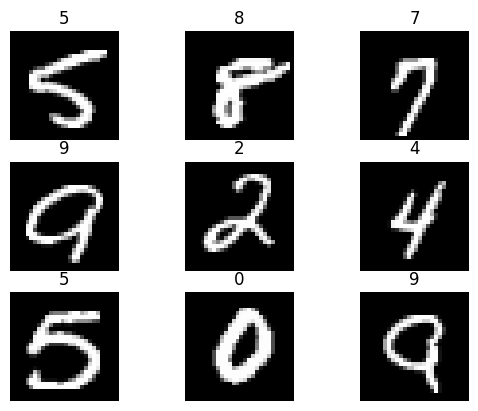

In [63]:
img, label = next(iter(train_dataloader))
label.shape, img.shape
fig, ax = plt.subplots(3, 3)

for i in range(3):
    for j in range(3):
        idx = i*3 + j 
        ax[i,j].imshow(img[idx].squeeze(), cmap='gray')
        ax[i,j].set_title(label[idx].item())
        ax[i,j].axis('off');


In [109]:
class TinyVGG(nn.Module):
    def __init__(self, IN, UN, OUT):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=IN, 
                      out_channels=UN, 
                      kernel_size=3,
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=UN, 
                      out_channels=UN,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) 
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(UN, UN, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(UN, UN, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=UN*7*7, 
                      out_features=OUT)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        
        return x

In [159]:
model = TinyVGG(IN=1, UN=10, OUT=len(classes_names))
model

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [160]:
img[0].shape

torch.Size([1, 28, 28])

In [161]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [162]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=0.1)

In [163]:
epochs = 5

for epoch in range(epochs):
    loss_mean, acc_mean = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()

        y_pred = model(X)

        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        loss_mean += loss.item()
        acc_mean += accuracy_fn(y, y_pred.argmax(dim=1))

        if batch%800 == 0:
            print(f"Epoch: {epoch} | Batch: {batch} | loss: {loss:.4f}")
    print(f"Epoch: {epoch}... Mean Loss: {loss_mean/len(train_dataloader):.4f} | Mean Acc: {acc_mean/len(train_dataloader):.2f}")

    loss_mean, acc_mean = 0, 0
    for batch, (X, y) in enumerate(test_dataloader):
        model.eval()
        with torch.inference_mode():
            y_pred = model(X)

        loss = loss_fn(y_pred, y)

        loss_mean += loss.item()
        acc_mean += accuracy_fn(y, y_pred.argmax(dim=1))
        
    print(f"   TEST  Epoch: {epoch}... Mean Loss: {loss_mean/len(test_dataloader):.4f} | Mean Acc: {acc_mean/len(test_dataloader):.2f}")

            

Epoch: 0 | Batch: 0 | loss: 2.3143
Epoch: 0 | Batch: 800 | loss: 0.1506
Epoch: 0 | Batch: 1600 | loss: 0.0377
Epoch: 0... Mean Loss: 0.2514 | Mean Acc: 91.72
   TEST  Epoch: 0... Mean Loss: 0.0660 | Mean Acc: 97.76
Epoch: 1 | Batch: 0 | loss: 0.0339
Epoch: 1 | Batch: 800 | loss: 0.1844
Epoch: 1 | Batch: 1600 | loss: 0.1021
Epoch: 1... Mean Loss: 0.0697 | Mean Acc: 97.84
   TEST  Epoch: 1... Mean Loss: 0.0448 | Mean Acc: 98.50
Epoch: 2 | Batch: 0 | loss: 0.0252
Epoch: 2 | Batch: 800 | loss: 0.0124
Epoch: 2 | Batch: 1600 | loss: 0.0511
Epoch: 2... Mean Loss: 0.0562 | Mean Acc: 98.22
   TEST  Epoch: 2... Mean Loss: 0.0419 | Mean Acc: 98.56
Epoch: 3 | Batch: 0 | loss: 0.0092
Epoch: 3 | Batch: 800 | loss: 0.0073
Epoch: 3 | Batch: 1600 | loss: 0.1319
Epoch: 3... Mean Loss: 0.0486 | Mean Acc: 98.49
   TEST  Epoch: 3... Mean Loss: 0.0411 | Mean Acc: 98.51
Epoch: 4 | Batch: 0 | loss: 0.0238
Epoch: 4 | Batch: 800 | loss: 0.0110
Epoch: 4 | Batch: 1600 | loss: 0.0181
Epoch: 4... Mean Loss: 0.0440 

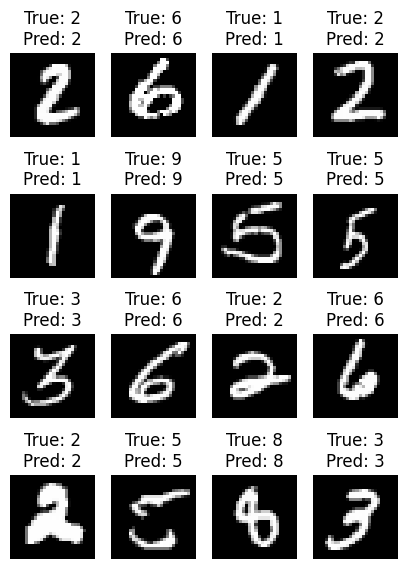

In [171]:
img, label = next(iter(train_dataloader))
label.shape, img.shape

fig, ax = plt.subplots(4, 4, figsize=(5, 7))

model.eval()
with torch.inference_mode():
    preds = model(img)

for i in range(4):
    for j in range(4):
        idx = i*4 + j 
        ax[i,j].imshow(img[idx].squeeze(), cmap='gray')
        ax[i,j].set_title(f"True: {label[idx].item()}\nPred: {torch.argmax(preds, dim=1)[idx]}")
        ax[i,j].axis('off');
